In [0]:
!pip3 install git+https://github.com/rtqichen/torchdiffeq.git
!pip3 install adabound

  Cloning https://github.com/rtqichen/torchdiffeq.git to /tmp/pip-req-build-eprmgnrr
  Running command git clone -q https://github.com/rtqichen/torchdiffeq.git /tmp/pip-req-build-eprmgnrr
  Stored in directory: /tmp/pip-ephem-wheel-cache-qgfjw2d2/wheels/f1/89/ce/78b4c1aabbb8dad56a2dbd776f9ffcbeca103b2ddae40d094b
Successfully built torchdiffeq


In [0]:
!pwd

/content


In [0]:
!nvidia-smi

Mon May 27 15:04:49 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   47C    P8    15W /  70W |      0MiB / 15079MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
from pathlib import Path

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader

from torchdiffeq import odeint_adjoint as odeint

import adabound

import time
import uuid
import copy
import collections
from collections import Counter
import json
from tqdm import tqdm
from PIL import Image
import matplotlib.pyplot as plt

import pandas as pd
import numpy as np

from sklearn import metrics

In [0]:
PACKERS_LANDSPACE = {
    0: 'ASPacK',
    1: 'Molebox',
    2: 'NsPack',
    3: 'PECompact',
    4: 'PeSpin',
    5: 'UPX',
    6: 'Normal'
}


# 参数
config = {
    "seed": 519,
    "cuda": True,
    "shuffle": True,
    "train_state_file": "train_state.json",
    "vectorizer_file": "vectorizer.json",
    "model_state_file": "model.pth",
    "performance_img": "performance.png",
    "confusion_matrix_img": "confusion_matrix_img.png",
    "save_dir": Path.cwd() / "experiments" / "main",
    # ODEnet
    "input_dim": 3,
    "state_dim": 64,
    "tol": 1e-5,
    # GRU
    "cutoff": 25,
    "num_layers": 1,
    "embedding_dim": 100,
    "kernels": [1, 3],
    "num_filters": 100,
    "rnn_hidden_dim": 64,
    "hidden_dim": 36,
    "dropout_p": 0.5,
    "bidirectional": False,
    # 超参数, [训练, 验证, 测试]
    "state_size": [0.7, 0.15, 0.15],
    "batch_size": 26,
    "num_epochs": 50,
    "early_stopping_criteria": 5,
    "learning_rate": 1e-5
}

In [0]:
# 生成唯一ID
def generate_unique_id():
    timestamp = int(time.time())
    unique_id = "{0}_{1}".format(timestamp, uuid.uuid1())
    return unique_id


# 设置随机种子
def set_seeds(seed, cuda):
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)


# 创建目录
def create_dirs(dirpath):
    if not dirpath.exists():
        dirpath.mkdir(parents=True)

In [0]:
def init():
    print("---->>>   PyTorch version: {}".format(torch.__version__))
    print("---->>>   Created {}".format(config["save_dir"]))
    # 设置种子
    set_seeds(seed=config["seed"], cuda=config["cuda"])
    print("---->>>   Set seeds.")
    # 检查是否有可用GPU
    config["cuda"] = True if torch.cuda.is_available() else False
    config["device"] = torch.device("cuda" if config["cuda"] else "cpu")
    print("---->>>   Using CUDA: {}".format(config["cuda"]))
    if config["cuda"] is True:
        print("---->>>   CUDA version: {}".format(torch.version.cuda))
        print("---->>>   GPU type: {}".format(torch.cuda.get_device_name(0)))
    # 设置当前实验ID
    config["experiment_id"] = generate_unique_id()
    config["save_dir"] = config["save_dir"] / config["experiment_id"]
    create_dirs(config["save_dir"])
    print("---->>>   Generated unique id: {0}".format(config["experiment_id"]))

In [0]:
init()

---->>>   PyTorch version: 1.1.0
---->>>   Created /content/experiments/main
---->>>   Set seeds.
---->>>   Using CUDA: True
---->>>   CUDA version: 10.0.130
---->>>   GPU type: Tesla T4
---->>>   Generated unique id: 1558969492_c779fa7c-8090-11e9-9c7e-0242ac1c0002


# 词汇表

In [0]:
# 词汇表：原始输入和数字形式的转换字典
class Vocabulary(object):
    def __init__(self, token_to_idx=None):

        # 令牌到索引
        if token_to_idx is None:
            token_to_idx = {}
        self.token_to_idx = token_to_idx

        # 索引到令牌
        self.idx_to_token = {
            idx: token
            for token, idx in self.token_to_idx.items()
        }

    def to_serializable(self):
        return {'token_to_idx': self.token_to_idx}

    @classmethod
    def from_serializable(cls, contents):
        return cls(**contents)

    def add_token(self, token):
        if token in self.token_to_idx:
            index = self.token_to_idx[token]
        else:
            index = len(self.token_to_idx)
            self.token_to_idx[token] = index
            self.idx_to_token[index] = token
        return index

    def add_tokens(self, tokens):
        return [self.add_token[token] for token in tokens]

    def lookup_token(self, token):
        return self.token_to_idx[token]

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError(
                "the index {0} is not in the Vocabulary".format(index))
        return self.idx_to_token[index]

    def __str__(self):
        return "<Vocabulary(size={0})>".format(len(self))

    def __len__(self):
        return len(self.token_to_idx)

In [0]:
# 序列化词汇表：实际图像的词汇表，存储标准差与平均值
class IMG_SequenceVocabulary():
    def __init__(self, train_means, train_stds):

        self.train_means = train_means
        self.train_stds = train_stds

    def to_serializable(self):
        contents = {
            'train_means': self.train_means,
            'train_stds': self.train_stds
        }
        return contents

    @classmethod
    def from_serializable(cls, contents):
        return cls(contents['train_means'], contents['train_stds'])

    @classmethod
    def from_dataframe(cls, df):
        train_data = df[df.split == "train"]
        means = {0: [], 1: [], 2: []}
        stds = {0: [], 1: [], 2: []}
        for image in train_data.image:
            for dim in range(3):
                means[dim].append(np.mean(image[:, :, dim]))
                stds[dim].append(np.std(image[:, :, dim]))
        train_means = np.array(
            (np.mean(means[0]), np.mean(means[1]), np.mean(means[2])),
            dtype="float64").tolist()
        train_stds = np.array(
            (np.mean(stds[0]), np.mean(stds[1]), np.mean(stds[2])),
            dtype="float64").tolist()

        return cls(train_means, train_stds)

    def __str__(self):
        return "<IMG_SequenceVocabulary(train_means: {0}, train_stds: {1}>".format(
            self.train_means, self.train_stds)

In [0]:
# 序列化词汇表：反汇编指令的词汇表，存储反汇编指令集
class INS_SequenceVocabulary(Vocabulary):
    def __init__(self,
                 token_to_idx=None,
                 unk_token="<UNK>",
                 mask_token="<MASK>",
                 begin_seq_token="<BEGIN>",
                 end_seq_token="<END>"):

        super(INS_SequenceVocabulary, self).__init__(token_to_idx)

        self.mask_token = mask_token
        self.unk_token = unk_token
        self.begin_seq_token = begin_seq_token
        self.end_seq_token = end_seq_token

        self.mask_index = self.add_token(self.mask_token)  # 0
        self.unk_index = self.add_token(self.unk_token)
        self.begin_seq_index = self.add_token(self.begin_seq_token)
        self.end_seq_index = self.add_token(self.end_seq_token)

    def to_serializable(self):
        contents = super(INS_SequenceVocabulary, self).to_serializable()
        contents.update({
            'unk_token': self.unk_token,
            'mask_token': self.mask_token,
            'begin_seq_token': self.begin_seq_token,
            'end_seq_token': self.end_seq_token
        })
        return contents

    @classmethod
    def from_serializable(cls, contents):
        return cls(contents['token_to_idx'], contents['unk_token'],
                   contents['mask_token'], contents['begin_seq_token'],
                   contents['end_seq_token'])

    def lookup_token(self, token):
        return self.token_to_idx.get(token, self.unk_index)

    def lookup_index(self, index):
        if index not in self.idx_to_token:
            raise KeyError(
                "the index ({0}) is not in the INS_SequenceVocabulary".format(
                    index))
        return self.idx_to_token[index]

    def __str__(self):
        return "<INS_SequenceVocabulary(size={0})>".format(
            len(self.token_to_idx))

    def __len__(self):
        return len(self.token_to_idx)

# 向量器

In [0]:
# 向量器：输入和输出的词汇表类实例
class Vectorizer(object):
    def __init__(self, image_vocab, ins_word_vocab, ins_char_vocab,
                 packer_vocab):
        self.image_vocab = image_vocab
        self.ins_word_vocab = ins_word_vocab
        self.ins_char_vocab = ins_char_vocab
        self.packer_vocab = packer_vocab

    # 向量化
    def vectorize(self, image, ins_s):
        # 防止改变实际的df
        image = np.copy(image)

        # 正则化
        for dim in range(3):
            mean = self.image_vocab.train_means[dim]
            std = self.image_vocab.train_stds[dim]
            image[:, :, dim] = ((image[:, :, dim] - mean) / std)

        # 把输入shape (a, a, b) 变为 (b, a, a)
        image = np.swapaxes(image, 0, 2)
        image = np.swapaxes(image, 1, 2)

        # 向量化每一个文件的汇编指令集序列
        indices = [
            self.ins_word_vocab.lookup_token(token)
            for token in ins_s.split(" ")
        ]

        indices = [self.ins_word_vocab.begin_seq_index
                   ] + indices + [self.ins_word_vocab.end_seq_index]

        # 词级向量
        ins_length = len(indices)
        word_vector = np.zeros(ins_length, dtype=np.int64)
        word_vector[:ins_length] = indices

        # 字符级向量
        word_length = max([len(word) for word in ins_s.split(" ")])
        char_vector = np.zeros((len(word_vector), word_length), dtype=np.int64)
        char_vector[0, :] = self.ins_word_vocab.mask_index  # <BEGIN>
        char_vector[-1, :] = self.ins_word_vocab.mask_index  # <END>
        for i, word in enumerate(ins_s.split(" ")):
            char_vector[i + 1, :len(word)] = [
                self.ins_char_vocab.lookup_token(char) for char in word
            ]

        return image, word_vector, char_vector, ins_length

    # 词级反向量化
    def unvectorize_word_vector(self, word_vector):
        tokens = [
            self.ins_word_vocab.lookup_index(index) for index in word_vector
        ]
        ins_ = " ".join(token for token in tokens)
        return ins_

    # 字符级反向量化
    def unvectorize_char_vector(self, char_vector):
        ins_ = ""
        for word_vector in char_vector:
            for index in word_vector:
                if index == self.ins_char_vocab.mask_index:
                    break
                ins_ += self.ins_char_vocab.lookup_index(index)
            ins_ += " "
        return ins_

    @classmethod
    def from_dataframe(cls, df, cutoff):

        # 创建壳类别词汇表
        packer_vocab = Vocabulary()
        for packer in sorted(set(df.packer)):
            packer_vocab.add_token(packer)

        # 创建图像词汇表
        image_vocab = IMG_SequenceVocabulary.from_dataframe(df)

        # 获取指令数目
        word_counts = Counter()
        for ins_ in df.ins:
            for token in ins_.split(" "):
                word_counts[token] += 1

        # 创建反汇编指令的词汇表实例(word)
        ins_word_vocab = INS_SequenceVocabulary()
        for word, word_count in word_counts.items():
            if word_count >= cutoff:
                ins_word_vocab.add_token(word)

        # 创建反汇编指令的词汇表实例(char)
        ins_char_vocab = INS_SequenceVocabulary()
        for ins_ in df.ins:
            for token in ins_:
                ins_char_vocab.add_token(token)

        return cls(image_vocab, ins_word_vocab, ins_char_vocab, packer_vocab)

    @classmethod
    def from_serializable(cls, contents):
        image_vocab = IMG_SequenceVocabulary.from_serializable(
            contents['image_vocab'])
        ins_word_vocab = INS_SequenceVocabulary.from_serializable(
            contents['ins_word_vocab'])
        ins_char_vocab = INS_SequenceVocabulary.from_serializable(
            contents['ins_char_vocab'])
        packer_vocab = Vocabulary.from_serializable(contents['packer_vocab'])
        return cls(image_vocab, ins_word_vocab, ins_char_vocab, packer_vocab)

    def to_serializable(self):
        return {
            'image_vocab': self.image_vocab.to_serializable(),
            'ins_word_vocab': self.ins_word_vocab.to_serializable(),
            'ins_char_vocab': self.ins_char_vocab.to_serializable(),
            'packer_vocab': self.packer_vocab.to_serializable()
        }

# 数据集

In [0]:
class Dataset(Dataset):
    def __init__(self, df, vectorizer):
        self.df = df
        self.vectorizer = vectorizer

        # 数据分割
        self.train_df = self.df[self.df.split == 'train']
        self.train_size = len(self.train_df)
        self.val_df = self.df[self.df.split == 'val']
        self.val_size = len(self.val_df)
        self.test_df = self.df[self.df.split == 'test']
        self.test_size = len(self.test_df)
        self.lookup_dict = {
            'train': (self.train_df, self.train_size),
            'val': (self.val_df, self.val_size),
            'test': (self.test_df, self.test_size)
        }
        self.set_split('train')

        # 分类权重（防止类别不平衡）
        class_counts = df.packer.value_counts().to_dict()

        def sort_key(item):
            return self.vectorizer.packer_vocab.lookup_token(item[0])

        sorted_counts = sorted(class_counts.items(), key=sort_key)
        frequencies = [count for _, count in sorted_counts]
        self.class_weights = 1.0 / torch.tensor(
            frequencies, dtype=torch.float32)

    @classmethod
    def load_dataset_and_make_vectorizer(cls, df, cutoff):
        train_df = df[df.split == 'train']
        return cls(df, Vectorizer.from_dataframe(train_df, cutoff))

    @classmethod
    def load_dataset_and_load_vectorizer(cls, df, vectorizer_filepath):
        vectorizer = cls.load_vectorizer_only(vectorizer_filepath)
        return cls(df, vectorizer)

    def load_vectorizer_only(vectorizer_filepath):
        with vectorizer_filepath.open() as fp:
            return Vectorizer.from_serializable(json.load(fp))

    def save_vectorizer(self, vectorizer_filepath):
        with vectorizer_filepath.open("w") as fp:
            json.dump(self.vectorizer.to_serializable(), fp)

    def set_split(self, split="train"):
        self.target_split = split
        self.target_df, self.target_size = self.lookup_dict[split]

    def __str__(self):
        return "<Dataset(split={0}, size={1})>".format(self.target_split,
                                                       self.target_size)

    def __len__(self):
        return self.target_size

    def __getitem__(self, index):
        row = self.target_df.iloc[index]
        image_vector, ins_word_vector, ins_char_vector, ins_length = self.vectorizer.vectorize(
            row.image, row.ins)
        packer_index = self.vectorizer.packer_vocab.lookup_token(row.packer)
        return {
            'image_vector': image_vector,
            'ins_word_vector': ins_word_vector,
            'ins_char_vector': ins_char_vector,
            'ins_length': ins_length,
            'packer': packer_index
        }

    def get_num_batches(self, batch_size):
        return len(self) // batch_size

    def generate_batches(self,
                         batch_size,
                         collate_fn,
                         shuffle=True,
                         drop_last=False,
                         device="cpu"):
        dataloader = DataLoader(
            dataset=self,
            batch_size=batch_size,
            collate_fn=collate_fn,
            shuffle=shuffle,
            drop_last=drop_last)
        for data_dict in tqdm(dataloader):
            out_data_dict = {}
            for name, tensor in data_dict.items():
                out_data_dict[name] = data_dict[name].to(device)
            yield out_data_dict

In [0]:
def get_datasets(csv_path=r"./train_data.pkl",
                 randam_seed=None,
                 state_size=[0.7, 0.15, 0.15],
                 vectorize=None):

    if np.sum(state_size) != 1.0 or any([i < 0 for i in state_size]):
        raise Exception("np.sum({0}) != 1 or not integer".format(state_size))
    if randam_seed is not None:
        np.random.seed(randam_seed)

    df = pd.read_pickle(csv_path)

    by_packer = collections.defaultdict(list)
    for _, row in df.iterrows():
        by_packer[row.packer].append(row.to_dict())

    print("---->>>   packer:")
    for packer in by_packer:
        print("{0}: {1}".format(packer, len(by_packer[packer])))

    final_list = []
    for _, item_list in sorted(by_packer.items()):
        np.random.shuffle(item_list)
        n = len(item_list)
        n_train = int(state_size[0] * n)
        n_val = int(state_size[1] * n)

        # 给数据点一个切分属性
        for item in item_list[:n_train]:
            item['split'] = 'train'
        for item in item_list[n_train:n_train + n_val]:
            item['split'] = 'val'
        for item in item_list[n_train + n_val:]:
            item['split'] = 'test'

        final_list.extend(item_list)

    split_df = pd.DataFrame(final_list)
    print(split_df.head())

    # 数据库实例
    if vectorize is None:
        dataset = Dataset.load_dataset_and_make_vectorizer(split_df, 5)
    else:
        dataset = Dataset.load_dataset_and_load_vectorizer(split_df, vectorize)
    return dataset

In [0]:
#datasets = get_datasets(randam_seed=22)
#vector = datasets.vectorizer

#print("image_vocab: {0}".format(vector.image_vocab))
#print("ins_word_vocab: {0}".format(vector.ins_word_vocab))
#print("ins_char_vocab: {0}".format(vector.ins_char_vocab))
#print("packer_vocab: {0}".format(vector.packer_vocab))

#print("datasets: {0}".format(datasets))
#print("datasets.class_weights: {0}".format(datasets.class_weights))

#input_ = datasets[10]  # __getitem__
#print("input_['image_vector']: {0}".format(input_['image_vector']))
#print("input_['ins_word_vector']: {0}".format(input_['ins_word_vector']))
#print("input_['ins_char_vector']: {0}".format(input_['ins_char_vector']))
#print("input_['ins_length']: {0}".format(input_['ins_length']))
#print("input_['packer']: {0}".format(input_['packer']))

# 模型

In [0]:
def norm(dim):
    return nn.GroupNorm(min(32, dim), dim)


class Flatten(nn.Module):
    def __init__(self):
        super(Flatten, self).__init__()

    def forward(self, x):
        shape = torch.prod(torch.tensor(x.shape[1:])).item()
        return x.view(-1, shape)

In [0]:
def add_time(in_tensor, t):
    bs, c, w, h = in_tensor.shape
    return torch.cat((in_tensor, t.expand(bs, 1, w, h)), dim=1)

class SE_ODEfunc(nn.Module):
    def __init__(self, dim):
        super(SE_ODEfunc, self).__init__()
        self.norm1 = norm(dim)
        self.relu = nn.ReLU(inplace=True)
        self.conv1 = nn.Conv2d(dim+1, dim, 3, 1, 1)
        self.norm2 = norm(dim)
        self.conv2 = nn.Conv2d(dim+1, dim, 3, 1, 1)
        self.norm3 = norm(dim)
        self.nfe = 0

    def forward(self, t, x):
        self.nfe += 1

        out = self.norm1(x)
        out = self.relu(out)
        
        # add_time
        tt = torch.ones_like(out[:, :1, :, :]) * t
        out = torch.cat([tt, out], 1)
        out = self.conv1(out)

        out = self.norm2(out)
        out = self.relu(out)
        # add_time
        tt = torch.ones_like(out[:, :1, :, :]) * t
        out = torch.cat([tt, out], 1)
        out = self.conv2(out)

        out = self.norm3(out)
        
        return out

class ODEBlock(nn.Module):
    def __init__(self, odefunc, rtol=1e-3, atol=1e-3):
        super(ODEBlock, self).__init__()
        self.odefunc = odefunc
        self.integration_time = torch.tensor([0, 1]).float()
        self.rtol = rtol
        self.atol = atol

    def forward(self, x, t=None):
        if t is not None:
            self.integration_time = t
        self.integration_time = self.integration_time.type_as(x)
        out = odeint(
            self.odefunc,
            x,
            self.integration_time,
            rtol=self.rtol,
            atol=self.atol)
        return out[1]

    @property
    def nfe(self):
        return self.odefunc.nfe

    @nfe.setter
    def nfe(self, value):
        self.odefunc.nfe = value

In [0]:
# 编码器
class InsEncoder(nn.Module):
    def __init__(self,
                 embedding_dim,
                 num_word_embeddings,
                 num_char_embeddings,
                 kernels,
                 num_input_channels,
                 num_output_channels,
                 rnn_hidden_dim,
                 num_layers,
                 bidirectional,
                 word_padding_idx=0,
                 char_padding_idx=0):
        super(InsEncoder, self).__init__()

        self.num_layers = num_layers
        self.bidirectional = bidirectional

        # 嵌入层
        self.word_embeddings = nn.Embedding(
            num_embeddings=num_word_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=word_padding_idx)
        self.char_embeddings = nn.Embedding(
            num_embeddings=num_char_embeddings,
            embedding_dim=embedding_dim,
            padding_idx=char_padding_idx)

        # 卷积层权重
        self.conv = nn.ModuleList([
            nn.Conv1d(
                in_channels=num_input_channels,
                out_channels=num_output_channels,
                kernel_size=kernel) for kernel in kernels
        ])

        # GRU层权重
        self.gru = nn.GRU(
            input_size=embedding_dim * (len(kernels) + 1),
            hidden_size=rnn_hidden_dim,
            num_layers=num_layers,
            batch_first=True,
            bidirectional=bidirectional)

        # ReLU
        self.relu = nn.ReLU(inplace=True)

    def get_char_level_embeddings(self, x):
        # x: (N, seq_len, word_len)
        batch_size, seq_len, word_len = x.size()
        # (N * seq_len, word_len)
        x = x.view(-1, word_len)

        # 嵌入层
        # (N * seq_len, word_len, embedding_dim)
        x = self.char_embeddings(x)

        # 重排使得embedding_dim在第一维
        # (N * seq_len, embedding_dim, word_len)
        x = x.transpose(1, 2)

        # 卷积层
        z = [self.relu(conv(x)) for conv in self.conv]

        # 池化
        z = [F.max_pool1d(zz, zz.size(2)).squeeze(2) for zz in z]
        z = [zz.view(batch_size, seq_len, -1) for zz in z]

        # 连接卷积输出得到字符级嵌入
        # (N, seq_size, embedding_dim * len(kernels))
        z = torch.cat(z, 2)

        return z

    def forward(self, x_word, x_char, x_lengths, device):
        # x_word: (N, seq_size)
        # x_char: (N, seq_size, word_len)

        # 词级嵌入层
        # (N, seq_size, embedding_dim)
        z_word = self.word_embeddings(x_word)

        # 字符级嵌入层
        # (N, seq_size, embedding_dim * len(kernels))
        z_char = self.get_char_level_embeddings(x_char)

        # 连接结果
        # (N, seq_size, embedding_dim * (len(kernels) + 1))
        z = torch.cat([z_word, z_char], 2)

        # 向RNN输入
        num_directions = 2 if self.bidirectional else 1
        initial_h = torch.zeros(self.num_layers * num_directions, z.size(0),
                                self.gru.hidden_size).to(device)
        out, h_n = self.gru(z, initial_h)

        return out


# 解码器
class InsDecoder(nn.Module):
    def __init__(self, rnn_hidden_dim, hidden_dim, output_dim, dropout_p):
        super(InsDecoder, self).__init__()

        # 注意力机制的全连接模型
        self.fc_attn = nn.Linear(rnn_hidden_dim, rnn_hidden_dim)
        self.v = nn.Parameter(torch.rand(rnn_hidden_dim))

        # 全连接参数
        self.fc_layers = nn.Sequential(
            nn.Dropout(dropout_p), nn.Linear(rnn_hidden_dim, hidden_dim),
            nn.ReLU(inplace=True), nn.Dropout(dropout_p),
            nn.Linear(hidden_dim, output_dim))

    def forward(self, encoder_outputs, apply_softmax=False):

        # 软注意
        z = torch.tanh(self.fc_attn(encoder_outputs))
        z = z.transpose(2, 1)  # [B*H*T]
        v = self.v.repeat(encoder_outputs.size(0), 1).unsqueeze(1)  # [B*1*H]
        z = torch.bmm(v, z).squeeze(1)  # [B*T]
        attn_scores = F.softmax(z, dim=1)
        context = torch.matmul(
            encoder_outputs.transpose(-2, -1),
            attn_scores.unsqueeze(dim=2)).squeeze()
        if len(context.size()) == 1:
            context = context.unsqueeze(0)

        # 全连接层
        y_pred = self.fc_layers(context)

        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)
        return attn_scores, y_pred

In [0]:
# (W-F+2P)/S
# (W-F)/S + 1
# ODEnet模型
class IngModel(nn.Module):
    def __init__(self,
                 input_dim,
                 state_dim,
                 output_dim,
                 tol=1e-3):
        super(IngModel, self).__init__()
        # 输入shape：(3,32,32)
        # self.transformer = ST()

        self.downsampling_layers = nn.Sequential(
            nn.Conv2d(input_dim, state_dim, 3, 1), norm(state_dim),
            nn.ReLU(inplace=True), nn.Conv2d(state_dim, state_dim, 4, 2, 1),
            norm(state_dim), nn.ReLU(inplace=True),
            nn.Conv2d(state_dim, state_dim, 4, 2, 1))

        self.feature_layers = ODEBlock(
            SE_ODEfunc(state_dim), rtol=tol, atol=tol)

        self.fc_layers = nn.Sequential(
            norm(state_dim), nn.ReLU(inplace=True), nn.AdaptiveAvgPool2d(1),
            Flatten(), nn.Linear(state_dim, output_dim))

    def forward(self, x_in, apply_softmax=False):
        # out = self.transformer(x_in)
        out = self.downsampling_layers(x_in)
        out = self.feature_layers(out)
        out = self.fc_layers(out)

        if apply_softmax:
            out = F.softmax(out, dim=1)

        return out

    @property
    def nfe(self):
        return self.feature_layers.nfe

    @nfe.setter
    def nfe(self, value):
        self.feature_layers.nfe = value

In [0]:
class InsModel(nn.Module):
    def __init__(self, embedding_dim, num_word_embeddings, num_char_embeddings,
                 kernels, num_input_channels, num_output_channels,
                 rnn_hidden_dim, hidden_dim, output_dim, num_layers,
                 bidirectional, dropout_p, word_padding_idx, char_padding_idx):
        super(InsModel, self).__init__()

        self.encoder = InsEncoder(
            embedding_dim, num_word_embeddings, num_char_embeddings, kernels,
            num_input_channels, num_output_channels, rnn_hidden_dim,
            num_layers, bidirectional, word_padding_idx, char_padding_idx)
        self.decoder = InsDecoder(rnn_hidden_dim, hidden_dim, output_dim,
                                  dropout_p)

    def forward(self, x_word, x_char, x_lengths, device, apply_softmax=False):
        encoder_outputs = self.encoder(x_word, x_char, x_lengths, device)
        y_pred = self.decoder(encoder_outputs, apply_softmax)
        return y_pred

In [0]:
class MainModel(nn.Module):
    def __init__(self, input_dim, state_dim, output_dim, tol,
                 embedding_dim, num_word_embeddings, num_char_embeddings,
                 kernels, num_input_channels, num_output_channels,
                 rnn_hidden_dim, hidden_dim, num_layers, bidirectional,
                 dropout_p, word_padding_idx, char_padding_idx):
        super(MainModel, self).__init__()

        self.img_layer = IngModel(
            input_dim=input_dim,
            output_dim=output_dim,
            state_dim=state_dim,
            tol=tol)

        self.ins_layer = InsModel(
            embedding_dim=embedding_dim,
            num_word_embeddings=num_word_embeddings,
            num_char_embeddings=num_char_embeddings,
            kernels=kernels,
            num_input_channels=num_input_channels,
            num_output_channels=num_output_channels,
            rnn_hidden_dim=rnn_hidden_dim,
            hidden_dim=hidden_dim,
            output_dim=output_dim,
            num_layers=num_layers,
            bidirectional=bidirectional,
            dropout_p=dropout_p,
            word_padding_idx=word_padding_idx,
            char_padding_idx=char_padding_idx)

        # 修改全连接层
        self.img_layer.fc_layers = self.img_layer.fc_layers[:-1]
        self.ins_layer.decoder.fc_layers = self.ins_layer.decoder.fc_layers[:2]

        # classifier
        self.classifier = nn.Sequential(
            nn.ReLU(inplace=True), nn.Dropout(dropout_p),
            nn.Linear(hidden_dim + state_dim, output_dim, bias=True))

    def forward(self,
                x_img,
                x_word,
                x_char,
                x_lengths,
                device,
                apply_softmax=False):

        img_out = self.img_layer(x_img)
        attn_scores, ins_out = self.ins_layer(x_word, x_char, x_lengths,
                                              device)

        x_cat = torch.cat((img_out, ins_out), 1)

        y_pred = self.classifier(x_cat)
        if apply_softmax:
            y_pred = F.softmax(y_pred, dim=1)

        return attn_scores, y_pred

#训练

In [0]:
def compute_accuracy(y_pred, y_target):
    _, y_pred_indices = y_pred.max(dim=1)
    n_correct = torch.eq(y_pred_indices, y_target).sum().item()
    return n_correct / len(y_pred_indices) * 100


def update_train_state(model, train_state):
    # 详细信息
    print(
        "[EPOCH]: {0} | [LR]: {1} | [TRAIN LOSS]: {2:.2f} | [TRAIN ACC]: {3:.1f}% | [VAL LOSS]: {4:.2f} | [VAL ACC]: {5:.1f}% | [NFE-F]: {6:.1f} | [NFE-B]: {7:.1f}"
        .format(train_state['epoch_index'], train_state['learning_rate'],
                train_state['train_loss'][-1], train_state['train_acc'][-1],
                train_state['val_loss'][-1], train_state['val_acc'][-1],
                train_state['f_nfe'][-1], train_state['b_nfe'][-1]))

    # 至少保存一次模型
    if train_state['epoch_index'] == 0:
        torch.save(
            model.state_dict(),
            str(train_state['save_dir'] / train_state['model_filename']))
        train_state['stop_early'] = False
    # 如果模型性能表现有提升，再次保存
    else:
        loss_tm1, loss_t = train_state['val_loss'][-2:]

        # 如果损失增大
        if loss_t + 0.003 >= loss_tm1:
            # 更新步数
            train_state['early_stopping_step'] += 1
        # 损失变小
        else:
            # 保存最优的模型
            if loss_t < train_state['early_stopping_best_val']:
                torch.save(
                    model.state_dict(),
                    str(train_state['save_dir'] /
                        train_state['model_filename']))
                train_state['early_stopping_best_val'] = loss_t

            # 重置早停的步数
            train_state['early_stopping_step'] = 0

        # 是否需要早停
        train_state['stop_early'] = train_state[
            'early_stopping_step'] >= train_state['early_stopping_criteria']
    return train_state


def save_train_state(train_state, save_dir):
    train_state["done_training"] = True
    train_state['save_dir'] = str(train_state['save_dir'])
    with save_dir.open("w") as fp:
        json.dump(train_state, fp)
    print("---->>>  Training complete!")


def plot_performance(train_state, save_dir, show_plot=True):
    """ Plot loss and accuracy.
    """
    # Figure size
    plt.figure(figsize=(15, 5))

    # Plot Loss
    plt.subplot(1, 2, 1)
    plt.xticks(list(range(train_state["epoch_index"]+1)))
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.plot(train_state["train_loss"], label="train")
    plt.plot(train_state["val_loss"], label="val")
    plt.legend(loc='upper right')

    # Plot Accuracy
    plt.subplot(1, 2, 2)
    plt.xticks(list(range(train_state["epoch_index"]+1)))
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.plot(train_state["train_acc"], label="train")
    plt.plot(train_state["val_acc"], label="val")
    plt.legend(loc='lower right')

    # Save figure
    plt.savefig(str(save_dir))

    # Show plots
    if show_plot:
        # print("---->>>   Metric plots:")
        plt.show()

    plt.close('all')


def Confusion_matrix(y_pred, y_target, classes_name, save_dir, show_plot=True):
    y_target = [i.cpu().numpy().tolist() for i in y_target]
    y_pred = [i.cpu().numpy().tolist() for i in y_pred]
    cm_mat = metrics.confusion_matrix(y_target, y_pred)

    
    cmap = plt.cm.get_cmap(
        'Greys'
    )  # 更多颜色: http://matplotlib.org/examples/color/colormaps_reference.html
    plt.imshow(cm_mat, cmap=cmap)
    plt.colorbar()

    # 设置文字
    xlocations = np.array(range(len(classes_name)))
    plt.xticks(xlocations, classes_name, rotation=60)
    plt.yticks(xlocations, classes_name)
    plt.xlabel('Predict label')
    plt.ylabel('True label')
    plt.title('Confusion_Matrix')

    # 打印数字
    for i in range(cm_mat.shape[0]):
        for j in range(cm_mat.shape[1]):
            plt.text(x=j, y=i, s=int(cm_mat[i, j]), va='center', ha='center', color='red', fontsize=10)

    # 保存
    plt.savefig(str(save_dir))

    if show_plot:
        # print("---->>>   Confusion Matrix:")
        plt.show()

    plt.close('all')

In [0]:
class Trainer(object):
    def __init__(self, dataset, model, save_dir, model_file, device, shuffle,
                 num_epochs, batch_size, learning_rate,
                 early_stopping_criteria):
        self.dataset = dataset
        self.class_weights = dataset.class_weights.to(device)
        self.model = model.to(device)
        self.device = device
        self.shuffle = shuffle
        self.num_epochs = num_epochs
        self.batch_size = batch_size
        self.loss_func = nn.CrossEntropyLoss(self.class_weights)
        self.optimizer = adabound.AdaBound(
            self.model.parameters(), lr=learning_rate)  # 新的优化方法
        #self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.scheduler = optim.lr_scheduler.ReduceLROnPlateau(
            optimizer=self.optimizer, mode='min', factor=0.5, patience=1)
        self.train_state = {
            'done_training': False,
            'stop_early': False,
            'early_stopping_step': 0,
            'early_stopping_best_val': 1e8,
            'early_stopping_criteria': early_stopping_criteria,
            'learning_rate': learning_rate,
            'epoch_index': 0,
            'train_loss': [],
            'train_acc': [],
            'val_loss': [],
            'val_acc': [],
            'test_loss': -1,
            'test_acc': -1,
            'save_dir': save_dir,
            'model_filename': model_file,
            "f_nfe": [],
            "b_nfe": []
        }

    def pad_word_seq(self, seq, length):
        vector = np.zeros(length, dtype=np.int64)
        vector[:len(seq)] = seq
        vector[len(seq):] = self.dataset.vectorizer.ins_word_vocab.mask_index
        return vector

    def pad_char_seq(self, seq, seq_length, word_length):
        vector = np.zeros((seq_length, word_length), dtype=np.int64)
        vector.fill(self.dataset.vectorizer.ins_char_vocab.mask_index)
        for i in range(len(seq)):
            char_padding = np.zeros(word_length - len(seq[i]), dtype=np.int64)
            vector[i] = np.concatenate((seq[i], char_padding), axis=None)
        return vector

    def collate_fn(self, batch):

        # 深度拷贝
        batch_copy = copy.deepcopy(batch)
        processed_batch = {
            'image_vector': [],
            'ins_word_vector': [],
            'ins_char_vector': [],
            'ins_length': [],
            'packer': []
        }

        # 得到最长序列长度
        max_seq_length = max(
            [len(sample["ins_word_vector"]) for sample in batch_copy])
        max_word_length = max(
            [len(sample["ins_char_vector"][0]) for sample in batch_copy])

        # 填充
        for i, sample in enumerate(batch_copy):
            padded_word_seq = self.pad_word_seq(sample["ins_word_vector"],
                                                max_seq_length)
            padded_cahr_seq = self.pad_char_seq(
                sample["ins_char_vector"], max_seq_length, max_word_length)
            processed_batch["image_vector"].append(sample["image_vector"])
            processed_batch["ins_word_vector"].append(padded_word_seq)
            processed_batch["ins_char_vector"].append(padded_cahr_seq)
            processed_batch["ins_length"].append(sample["ins_length"])
            processed_batch["packer"].append(sample["packer"])

        # 转换为合适的tensor
        processed_batch["image_vector"] = torch.FloatTensor(
            processed_batch["image_vector"])
        processed_batch["ins_word_vector"] = torch.LongTensor(
            processed_batch["ins_word_vector"])
        processed_batch["ins_char_vector"] = torch.LongTensor(
            processed_batch["ins_char_vector"])
        processed_batch["ins_length"] = torch.LongTensor(
            processed_batch["ins_length"])
        processed_batch["packer"] = torch.LongTensor(processed_batch["packer"])

        return processed_batch

    def run_train_loop(self):
        print("---->>>   Training:")
        for epoch_index in range(self.num_epochs):
            self.train_state['epoch_index'] = epoch_index

            # 遍历训练集

            torch.cuda.empty_cache()

            # 初始化批生成器, 设置为训练模式，损失和准确率归零
            self.dataset.set_split('train')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=self.shuffle,
                device=self.device)
            running_loss = []
            running_acc = []
            f_nfe, b_nfe = [], []
            self.model.nfe = 0
            self.model.train()

            for batch_index, batch_dict in enumerate(batch_generator):
                # 梯度归零
                self.optimizer.zero_grad()

                # 计算输出
                _, y_pred = self.model(
                    x_img=batch_dict['image_vector'],
                    x_word=batch_dict['ins_word_vector'],
                    x_char=batch_dict['ins_char_vector'],
                    x_lengths=batch_dict['ins_length'],
                    device=self.device)

                # 计算损失
                loss = self.loss_func(y_pred, batch_dict['packer'])
                loss_t = loss.item()
                running_loss.append(loss_t)

                f_nfe.append(self.model.img_layer.nfe)
                self.model.img_layer.nfe = 0

                # 反向传播
                loss.backward()

                # 更新梯度
                self.optimizer.step()

                b_nfe.append(self.model.img_layer.nfe)
                self.model.img_layer.nfe = 0

                # 计算准确率
                acc_t = compute_accuracy(y_pred, batch_dict['packer'])
                running_acc.append(acc_t)

            self.train_state['train_loss'].append(
                sum(running_loss) / len(running_loss))
            self.train_state['train_acc'].append(
                sum(running_acc) / len(running_acc))
            # self.train_state['train_loss'].append(loss_t)
            # self.train_state['train_acc'].append(acc_t)
            self.train_state['f_nfe'].append(sum(f_nfe) / len(f_nfe))
            self.train_state['b_nfe'].append(sum(b_nfe) / len(b_nfe))

            # 遍历验证集

            torch.cuda.empty_cache()

            # 初始化批生成器, 设置为验证模式，损失和准确率归零
            self.dataset.set_split('val')
            batch_generator = self.dataset.generate_batches(
                batch_size=self.batch_size,
                collate_fn=self.collate_fn,
                shuffle=self.shuffle,
                device=self.device)
            running_loss = []
            running_acc = []
            self.model.eval()

            for batch_index, batch_dict in enumerate(batch_generator):

                # 计算输出
                _, y_pred = self.model(
                    x_img=batch_dict['image_vector'],
                    x_word=batch_dict['ins_word_vector'],
                    x_char=batch_dict['ins_char_vector'],
                    x_lengths=batch_dict['ins_length'],
                    device=self.device)

                # 计算损失
                loss = self.loss_func(y_pred, batch_dict['packer'])
                loss_t = loss.item()
                running_loss.append(loss_t)

                # 计算准确率
                acc_t = compute_accuracy(y_pred, batch_dict['packer'])
                running_acc.append(acc_t)

            self.train_state['val_loss'].append(
                sum(running_loss) / len(running_loss))
            self.train_state['val_acc'].append(
                sum(running_acc) / len(running_acc))
            # self.train_state['val_loss'].append(loss_t)
            # self.train_state['val_acc'].append(acc_t)

            # 学习率
            self.scheduler.step(self.train_state['val_loss'][-1])
            self.train_state['learning_rate'] = float(
                list(self.optimizer.param_groups)[-1]['lr'])
            self.train_state = update_train_state(
                model=self.model, train_state=self.train_state)

            if self.train_state['stop_early']:
                break

    def run_test_loop(self):
        torch.cuda.empty_cache()

        # 初始化批生成器, 设置为测试模式，损失和准确率归零
        self.dataset.set_split('test')
        batch_generator = self.dataset.generate_batches(
            batch_size=self.batch_size,
            collate_fn=self.collate_fn,
            shuffle=self.shuffle,
            device=self.device)
        running_loss = []
        running_acc = []
        self.model.eval()

        all_pred = []
        all_pack = []

        for batch_index, batch_dict in enumerate(batch_generator):
            # 计算输出
            _, y_pred = self.model(
                x_img=batch_dict['image_vector'],
                x_word=batch_dict['ins_word_vector'],
                x_char=batch_dict['ins_char_vector'],
                x_lengths=batch_dict['ins_length'],
                device=self.device)

            # 计算损失
            loss = self.loss_func(y_pred, batch_dict['packer'])
            loss_t = loss.item()
            running_loss.append(loss_t)

            # 计算准确率
            acc_t = compute_accuracy(y_pred, batch_dict['packer'])
            running_acc.append(acc_t)

            all_pred.extend(y_pred.max(dim=1)[1])
            all_pack.extend(batch_dict['packer'])

        self.train_state['test_loss'] = sum(running_loss) / len(running_loss)
        self.train_state['test_acc'] = sum(running_acc) / len(running_acc)

        classes_name = [
            self.dataset.vectorizer.packer_vocab.lookup_index(i)
            for i in range(
                len(self.dataset.vectorizer.packer_vocab))
        ]

        # 混淆矩阵
        # print("---->>>   Confusion Matrix:")
        Confusion_matrix(
            y_pred=all_pred,
            y_target=all_pack,
            classes_name=classes_name,
            save_dir=config["save_dir"] / config["confusion_matrix_img"],
            show_plot=True)

        # 详细信息
        print("---->>>   Test performance:")
        print("Test loss: {0:.2f}".format(self.train_state['test_loss']))
        print("Test Accuracy: {0:.1f}%".format(self.train_state['test_acc']))
        
        return all_pack, all_pred, classes_name

In [0]:
# 加载数据集
dataset = get_datasets(
    csv_path=r"./train_data.pkl",
    randam_seed=config["seed"],
    state_size=config["state_size"],
    vectorize=None)

---->>>   packer:
ASPack: 519
Molebox: 360
Normal: 2045
NsPack: 266
PECompact: 329
PeSpin: 369
UPX: 408
                                               image  ...  split
0  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
1  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
2  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
3  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
4  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train

[5 rows x 4 columns]


In [0]:
# 保存向量器
dataset.save_vectorizer(config["save_dir"] / config["vectorizer_file"])

In [0]:
# 初始化神经网络
vectorizer = dataset.vectorizer
model = MainModel(
    input_dim=config["input_dim"],
    state_dim=config["state_dim"],
    tol=config["tol"],
    embedding_dim=config["embedding_dim"],
    num_word_embeddings=len(vectorizer.ins_word_vocab),
    num_char_embeddings=len(vectorizer.ins_char_vocab),
    kernels=config["kernels"],
    num_input_channels=config["embedding_dim"],
    num_output_channels=config["num_filters"],
    rnn_hidden_dim=config["rnn_hidden_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=len(vectorizer.packer_vocab),
    num_layers=config["num_layers"],
    bidirectional=config["bidirectional"],
    dropout_p=config["dropout_p"],
    word_padding_idx=vectorizer.ins_word_vocab.mask_index,
    char_padding_idx=vectorizer.ins_char_vocab.mask_index)
print(model.named_modules)

<bound method Module.named_modules of MainModel(
  (img_layer): IngModel(
    (downsampling_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): GroupNorm(32, 64, eps=1e-05, affine=True)
      (5): ReLU(inplace)
      (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    )
    (feature_layers): ODEBlock(
      (odefunc): SE_ODEfunc(
        (norm1): GroupNorm(32, 64, eps=1e-05, affine=True)
        (relu): ReLU(inplace)
        (conv1): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm2): GroupNorm(32, 64, eps=1e-05, affine=True)
        (conv2): Conv2d(65, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
        (norm3): GroupNorm(32, 64, eps=1e-05, affine=True)
      )
    )
    (fc_layers): Sequential(
      (0): GroupNorm(32, 64, eps=1

In [0]:
# 初始化训练器
trainer = Trainer(
    dataset=dataset,
    model=model,
    save_dir=config["save_dir"],
    model_file=config["model_state_file"],
    device=config["device"],
    shuffle=config["shuffle"],
    num_epochs=config["num_epochs"],
    batch_size=config["batch_size"],
    learning_rate=config["learning_rate"],
    early_stopping_criteria=config["early_stopping_criteria"])

In [28]:
# 训练
trainer.run_train_loop()

  0%|          | 0/116 [00:00<?, ?it/s]

---->>>   Training:


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 0 | [LR]: 1e-05 | [TRAIN LOSS]: 1.81 | [TRAIN ACC]: 30.6% | [VAL LOSS]: 1.55 | [VAL ACC]: 47.2% | [NFE-F]: 74.0 | [NFE-B]: 94.3


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 1 | [LR]: 1e-05 | [TRAIN LOSS]: 1.24 | [TRAIN ACC]: 63.2% | [VAL LOSS]: 0.76 | [VAL ACC]: 94.6% | [NFE-F]: 88.7 | [NFE-B]: 92.6


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 2 | [LR]: 1e-05 | [TRAIN LOSS]: 0.58 | [TRAIN ACC]: 86.5% | [VAL LOSS]: 0.26 | [VAL ACC]: 97.5% | [NFE-F]: 77.8 | [NFE-B]: 81.6


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 3 | [LR]: 1e-05 | [TRAIN LOSS]: 0.41 | [TRAIN ACC]: 87.2% | [VAL LOSS]: 0.20 | [VAL ACC]: 96.6% | [NFE-F]: 68.9 | [NFE-B]: 74.4


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 4 | [LR]: 1e-05 | [TRAIN LOSS]: 0.14 | [TRAIN ACC]: 97.5% | [VAL LOSS]: 0.06 | [VAL ACC]: 98.7% | [NFE-F]: 62.2 | [NFE-B]: 63.1


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 5 | [LR]: 1e-05 | [TRAIN LOSS]: 0.07 | [TRAIN ACC]: 98.6% | [VAL LOSS]: 0.05 | [VAL ACC]: 97.7% | [NFE-F]: 60.9 | [NFE-B]: 64.2


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 6 | [LR]: 1e-05 | [TRAIN LOSS]: 0.07 | [TRAIN ACC]: 98.4% | [VAL LOSS]: 0.04 | [VAL ACC]: 99.1% | [NFE-F]: 58.9 | [NFE-B]: 58.5


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 7 | [LR]: 1e-05 | [TRAIN LOSS]: 0.05 | [TRAIN ACC]: 98.7% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.7% | [NFE-F]: 56.1 | [NFE-B]: 56.4


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 8 | [LR]: 1e-05 | [TRAIN LOSS]: 0.03 | [TRAIN ACC]: 99.5% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.5% | [NFE-F]: 55.1 | [NFE-B]: 56.5


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 9 | [LR]: 1e-05 | [TRAIN LOSS]: 0.03 | [TRAIN ACC]: 99.5% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.5% | [NFE-F]: 53.6 | [NFE-B]: 57.1


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 10 | [LR]: 1e-05 | [TRAIN LOSS]: 0.02 | [TRAIN ACC]: 99.8% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.7% | [NFE-F]: 54.9 | [NFE-B]: 57.7


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 11 | [LR]: 1e-05 | [TRAIN LOSS]: 0.02 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.2% | [NFE-F]: 53.5 | [NFE-B]: 57.2


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 12 | [LR]: 1e-05 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.7% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.7% | [NFE-F]: 53.9 | [NFE-B]: 57.2


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 13 | [LR]: 1e-05 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.5% | [NFE-F]: 53.5 | [NFE-B]: 57.1


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 14 | [LR]: 5e-06 | [TRAIN LOSS]: 0.02 | [TRAIN ACC]: 99.6% | [VAL LOSS]: 0.04 | [VAL ACC]: 99.4% | [NFE-F]: 55.5 | [NFE-B]: 59.9


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 15 | [LR]: 5e-06 | [TRAIN LOSS]: 0.02 | [TRAIN ACC]: 99.4% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.7% | [NFE-F]: 55.0 | [NFE-B]: 52.1


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 16 | [LR]: 2.5e-06 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.8% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.7% | [NFE-F]: 53.5 | [NFE-B]: 53.6


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 17 | [LR]: 2.5e-06 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.5 | [NFE-B]: 54.7


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 18 | [LR]: 1.25e-06 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.1


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 19 | [LR]: 1.25e-06 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.8% | [NFE-F]: 53.5 | [NFE-B]: 56.5


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 20 | [LR]: 6.25e-07 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.7


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 21 | [LR]: 6.25e-07 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.5


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 22 | [LR]: 3.125e-07 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 100.0% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.5 | [NFE-B]: 56.4


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 23 | [LR]: 3.125e-07 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 100.0% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.5


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 24 | [LR]: 1.5625e-07 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.4


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 25 | [LR]: 1.5625e-07 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 100.0% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.5


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 26 | [LR]: 7.8125e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.5 | [NFE-B]: 56.3


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 27 | [LR]: 7.8125e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.02 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.2


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 28 | [LR]: 3.90625e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.5 | [NFE-B]: 56.1


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 29 | [LR]: 3.90625e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 100.0% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.4


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 30 | [LR]: 1.953125e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.2


  0%|          | 0/116 [00:00<?, ?it/s]

[EPOCH]: 31 | [LR]: 1.953125e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.4 | [NFE-B]: 56.4


100%|██████████| 25/25 [00:08<00:00,  3.24it/s]

[EPOCH]: 32 | [LR]: 1.953125e-08 | [TRAIN LOSS]: 0.01 | [TRAIN ACC]: 99.9% | [VAL LOSS]: 0.03 | [VAL ACC]: 99.8% | [NFE-F]: 53.5 | [NFE-B]: 56.5


In [29]:
# 保存网络状态
save_train_state(
    train_state=trainer.train_state,
    save_dir=config["save_dir"] / config["train_state_file"])

---->>>  Training complete!


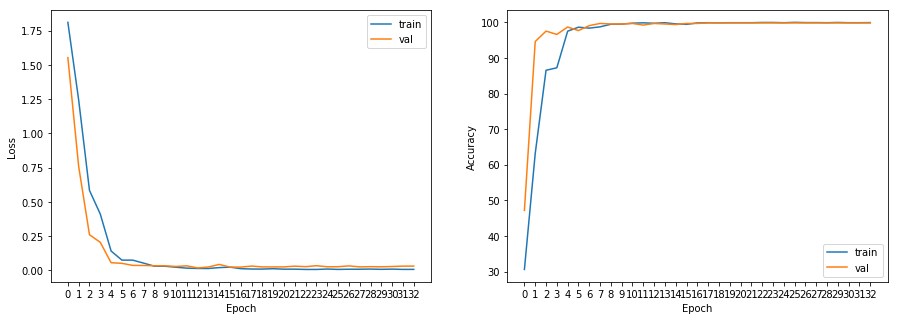

In [30]:
# 训练状态图
plot_performance(
    train_state=trainer.train_state,
    save_dir=config["save_dir"] / config["performance_img"],
    show_plot=True)

100%|██████████| 26/26 [00:08<00:00,  3.09it/s]


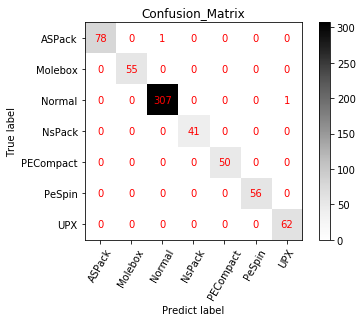

---->>>   Test performance:
Test loss: 0.02
Test Accuracy: 99.7%


In [31]:
# 测试
y_test, y_predict, classes_name = trainer.run_test_loop()

In [32]:
y_test = [i.cpu().numpy().tolist() for i in y_test]
y_predict = [i.cpu().numpy().tolist() for i in y_predict]

p_vocab = trainer.dataset.vectorizer.packer_vocab

y_test = [p_vocab.lookup_index(i) for i in y_test]
y_predict = [p_vocab.lookup_index(i) for i in y_predict]

print('分类报告:\n', metrics.classification_report(y_test, y_predict,labels=classes_name))#分类报告输出

分类报告:
               precision    recall  f1-score   support

      ASPack       1.00      0.99      0.99        79
     Molebox       1.00      1.00      1.00        55
      Normal       1.00      1.00      1.00       308
      NsPack       1.00      1.00      1.00        41
   PECompact       1.00      1.00      1.00        50
      PeSpin       1.00      1.00      1.00        56
         UPX       0.98      1.00      0.99        62

    accuracy                           1.00       651
   macro avg       1.00      1.00      1.00       651
weighted avg       1.00      1.00      1.00       651



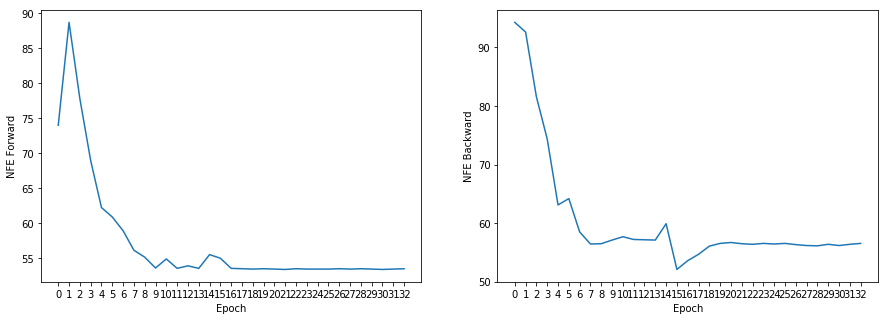

In [33]:

# Figure size
plt.figure(figsize=(15, 5))

# Plot Loss
plt.subplot(1, 2, 1)
plt.xticks(list(range(trainer.train_state["epoch_index"]+1)))
plt.xlabel("Epoch")
plt.ylabel("NFE Forward")
plt.plot(trainer.train_state["f_nfe"])

# Plot Accuracy
plt.subplot(1, 2, 2)
plt.xticks(list(range(trainer.train_state["epoch_index"]+1)))
plt.xlabel("Epoch")
plt.ylabel("NFE Backward")
plt.plot(trainer.train_state["b_nfe"])

# Save figure
plt.savefig(str(config["save_dir"] / "nfe"))

# Show plots
plt.show()

plt.close('all')

# 预测

In [0]:
class Inference(object):
    def __init__(self, model, vectorizer):
        self.model = model
        self.vectorizer = vectorizer

    def predict_packer(self, image, ins):
        # Vectorize
        image_vector, ins_word_vector, ins_char_vector, ins_length = self.vectorizer.vectorize(image, ins)
        
        image_vector = torch.FloatTensor(image_vector).unsqueeze(0)
        ins_word_vector = torch.tensor(ins_word_vector).unsqueeze(0)
        ins_char_vector = torch.tensor(ins_char_vector).unsqueeze(0)
        ins_length = torch.tensor([ins_length]).long()

        # Forward pass
        self.model.eval()
        attn_scores, y_pred = self.model(x_img=image_vector,
                                         x_word=ins_word_vector,
                                         x_char=ins_char_vector,
                                         x_lengths=ins_length,
                                         device="cpu",
                                         apply_softmax=True)

        # Top packer
        y_prob, indices = y_pred.max(dim=1)
        index = indices.item()

        # Predicted packer
        packer = vectorizer.packer_vocab.lookup_index(index)
        probability = y_prob.item()
        return {'packer': packer, 'probability': probability, 
                'attn_scores': attn_scores}

    def predict_top_k(self, image, ins, k):
        # Vectorize
        image_vector, ins_word_vector, ins_char_vector, ins_length = self.vectorizer.vectorize(image, ins)
        
        image_vector = torch.FloatTensor(image_vector).unsqueeze(0)
        ins_word_vector = torch.tensor(ins_word_vector).unsqueeze(0)
        ins_char_vector = torch.tensor(ins_char_vector).unsqueeze(0)
        ins_length = torch.tensor([ins_length]).long()

         # Forward pass
        self.model.eval()
        _, y_pred = self.model(x_img=image_vector,
                               x_word=ins_word_vector,
                               x_char=ins_char_vector,
                               x_lengths=ins_length,
                               device="cpu",
                               apply_softmax=True)
        
        # Top k packer
        y_prob, indices = torch.topk(y_pred, k=k)
        probabilities = y_prob.detach().numpy()[0]
        indices = indices.detach().numpy()[0]

        # Results
        results = []
        for probability, index in zip(probabilities, indices):
            packer = self.vectorizer.packer_vocab.lookup_index(index)
            results.append({'packer': packer, 'probability': probability})

        return results

In [35]:
# Load the model
# 加载数据集
dataset = get_datasets(
    csv_path=r"./train_data.pkl",
    randam_seed=config["seed"],
    state_size=config["state_size"],
    vectorize=config["save_dir"] / config["vectorizer_file"])

Vectorizer = dataset.vectorizer
model = MainModel(
    input_dim=config["input_dim"],
    state_dim=config["state_dim"],
    tol=config["tol"],
    embedding_dim=config["embedding_dim"],
    num_word_embeddings=len(vectorizer.ins_word_vocab),
    num_char_embeddings=len(vectorizer.ins_char_vocab),
    kernels=config["kernels"],
    num_input_channels=config["embedding_dim"],
    num_output_channels=config["num_filters"],
    rnn_hidden_dim=config["rnn_hidden_dim"],
    hidden_dim=config["hidden_dim"],
    output_dim=len(vectorizer.packer_vocab),
    num_layers=config["num_layers"],
    bidirectional=config["bidirectional"],
    dropout_p=config["dropout_p"],
    word_padding_idx=vectorizer.ins_word_vocab.mask_index,
    char_padding_idx=vectorizer.ins_char_vocab.mask_index)
model.load_state_dict(torch.load(config['save_dir'] / config['model_state_file']))
model = model.to("cpu")
print (model.named_modules)

---->>>   packer:
ASPack: 519
Molebox: 360
Normal: 2045
NsPack: 266
PECompact: 329
PeSpin: 369
UPX: 408
                                               image  ...  split
0  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
1  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
2  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
3  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train
4  [[[96.0, 0.0, 0.0], [232.0, 3.0, 0.0], [93.0, ...  ...  train

[5 rows x 4 columns]
<bound method Module.named_modules of MainModel(
  (img_layer): IngModel(
    (downsampling_layers): Sequential(
      (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1))
      (1): GroupNorm(32, 64, eps=1e-05, affine=True)
      (2): ReLU(inplace)
      (3): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
      (4): GroupNorm(32, 64, eps=1e-05, affine=True)
      (5): ReLU(inplace)
      (6): Conv2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
 

In [0]:
df = pd.read_pickle("./train_data.pkl")

In [37]:
print(df.image[777],df.ins[777],df.packer[777])

[[[232.   0.   0.]
  [ 96.   0.   0.]
  [232.  79.   0.]
  ...
  [107. 192.  40.]
  [139.  77. 252.]
  [  3. 200.   0.]]

 [[139.  85. 188.]
  [107. 210.  40.]
  [ 43. 202.   0.]
  ...
  [139.  85. 224.]
  [105. 210.  13.]
  [129. 194. 117.]]

 [[137.  85. 224.]
  [139.  69. 192.]
  [139.   8.   0.]
  ...
  [139.  85. 224.]
  [105. 210.  13.]
  [129. 194. 117.]]

 ...

 [[137.  85. 224.]
  [139.  69. 192.]
  [139.   8.   0.]
  ...
  [139.  85. 224.]
  [105. 210.  13.]
  [129. 194. 117.]]

 [[137.  85. 224.]
  [139.  69. 192.]
  [139.   8.   0.]
  ...
  [139.  85. 224.]
  [105. 210.  13.]
  [129. 194. 117.]]

 [[137.  85. 224.]
  [139.  69. 192.]
  [139.   8.   0.]
  ...
  [139.  85. 224.]
  [105. 210.  13.]
  [129. 194. 117.]]] call pushad call call call push mov sub push push push call mov push push call mov mov sub mov mov sub mov mov mov mov mov mov mov imul mov add mov imul sub mov mov add mov mov mov add mov mov mov add mov add mov mov cmp jnbe mov cmp jnb mov mov jmp mov cmp jnb 

In [0]:
img = df.image[7]
ins = df.ins[7]
packer = df.packer[7]

In [39]:
inference = Inference(model=model, vectorizer=vectorizer)
# title = input("Enter a title to classify: ")
prediction = inference.predict_packer(img, ins)
print("{} → {} (p={:0.2f})".format(packer, prediction['packer'], 
                                   prediction['probability']))

ASPack → ASPack (p=1.00)


In [40]:
# Top-k inference
top_k = inference.predict_top_k(img, ins, k=len(vectorizer.packer_vocab))
print ("{}: ".format(packer))
for result in top_k:
    print ("{} (p={:0.2f})".format(result['packer'], 
                                   result['probability']))

ASPack: 
ASPack (p=1.00)
Molebox (p=0.00)
PeSpin (p=0.00)
Normal (p=0.00)
NsPack (p=0.00)
PECompact (p=0.00)
UPX (p=0.00)


In [41]:
attn_matrix = prediction['attn_scores'].detach().numpy()[0]
attn_matrix_dict = {i:j for i,j in enumerate(attn_matrix)}
list1 = sorted(attn_matrix_dict.items(),key=lambda x:x[1])
print(list1)

[(15, 6.493834e-08), (88, 7.904657e-08), (104, 7.937676e-08), (136, 7.937873e-08), (120, 7.937881e-08), (152, 7.937881e-08), (168, 7.937881e-08), (184, 7.937881e-08), (200, 7.937881e-08), (232, 7.937881e-08), (248, 7.937881e-08), (264, 7.937881e-08), (296, 7.937881e-08), (312, 7.937881e-08), (344, 7.937881e-08), (360, 7.937881e-08), (408, 7.937881e-08), (440, 7.937881e-08), (472, 7.937881e-08), (488, 7.937881e-08), (520, 7.937881e-08), (536, 7.937881e-08), (584, 7.937881e-08), (616, 7.937881e-08), (648, 7.937881e-08), (664, 7.937881e-08), (696, 7.937881e-08), (712, 7.937881e-08), (760, 7.937881e-08), (792, 7.937881e-08), (824, 7.937881e-08), (840, 7.937881e-08), (872, 7.937881e-08), (888, 7.937881e-08), (936, 7.937881e-08), (968, 7.937881e-08), (1000, 7.937881e-08), (216, 7.937888e-08), (280, 7.937888e-08), (328, 7.937888e-08), (376, 7.937888e-08), (392, 7.937888e-08), (424, 7.937888e-08), (456, 7.937888e-08), (504, 7.937888e-08), (552, 7.937888e-08), (568, 7.937888e-08), (600, 7.93788

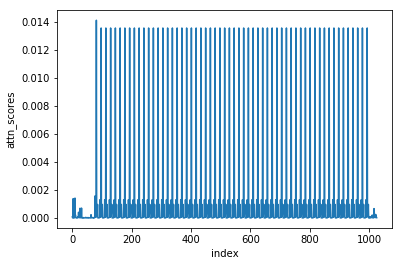

In [42]:
plt.xlabel("index")
plt.ylabel("attn_scores")
plt.plot(attn_matrix)

plt.savefig(str(config["save_dir"] / "attn"))

plt.show()


plt.close('all')